In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import re
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# My attempt on titnaic problem from Kaggle
# https://www.kaggle.com/competitions/titanic/overview
# with minimal/occaasional reference from:
# https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
#
# Code to predict who survived in titanic sinking


2022-04-07 16:17:09.163536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 16:17:09.163573: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [282]:
#Get Data
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)

#Check Columns/Features
print(train_dataset.columns.values)
print(test_dataset.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [283]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [284]:
#Check info, eg. which have NaN (In this case Age, Cabin, Embarked)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [285]:
test_dataset.info() 
#Age, Fare, Cabin


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [286]:
train_dataset.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [311]:
#Data "cleaning"(?) 
# Get new data from existing data 
# fill NaN data

#GET DATA AGAIN lol
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)

combine = [train_dataset,test_dataset]

for dataset in combine:
    #Family Size
    dataset["FamSize"]=dataset["SibSp"]+dataset["Parch"]
    
    #Alone or not
    dataset["Alone"] =  (dataset["FamSize"]  == 0)

    #Fill in the blanks
    dataset["Age"] = dataset["Age"].fillna(value=-1)
    dataset["Embarked"] = dataset["Embarked"].fillna(value="-")
    dataset["Fare"] = dataset["Fare"].fillna(value=-1)
    dataset["Cabin"] =  dataset["Cabin"].fillna(value=0)
    
    # Update Cabin Data
    dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
    #print(dataset["CabinGroup"].unique())
    Cabingroup = ["A", "B", "C", "D", "E", "F", "G", "T"]
    for i in Cabingroup:
        dataset[i] =     dataset["CabinGroup"].str.count(i)
        dataset[i] =     dataset[i].fillna(value=0)
        #print(dataset[[i, "Survived"]].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False))
    
    #Number of Cabin
    dataset["NumOfCabin"] = dataset["CabinGroup"].str.split(" ").str.len()
    dataset["NumOfCabin"] = dataset["NumOfCabin"].fillna(value=0)

    #Ticket Number
    dataset['TicketNum']= dataset["Ticket"].str.split(" ").str[-1]
    dataset ['TicketNum'] = pd.to_numeric(dataset['TicketNum'], errors='coerce')
    dataset ['TicketNum'] = dataset['TicketNum'].replace(np.nan, -1, regex=True)

    #Name
    dataset["First Name"] = dataset['Name'].str.split(",").str[0]
    dataset["Last Name"] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1].str.split(" ").str[-1]
    #dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Last Name'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1]
    

    #Title
    dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Title'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[0]
    dataset["Title"] = dataset["Title"].replace(" Ms", " Miss")
    dataset['Title'] = dataset['Title'].replace([' Lady', ' Countess',' Capt', ' Col', 	' Don', ' Dr', ' Major', ' Rev', ' Sir', ' Jonkheer', ' Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

/tmp/ipykernel_487684/2955488955.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
/tmp/ipykernel_487684/2955488955.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')


In [291]:

##Try to see any correlation with the initials and survival rate


#train_dataset["F"] =  train_dataset['First Name'].str[0].sort_values().reset_index(drop=True)
#train_dataset["L"] =  train_dataset['Last Name'].str[0].sort_values().reset_index(drop=True)
#with pd.option_context('display.max_rows', None,):
#   print(train_dataset[['F', "Survived"]].groupby(["F"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))
#   print(train_dataset[['L', "Survived"]].groupby(["L"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))
#
#g = sns.FacetGrid(train_dataset,col="Survived",size=10)
#g.map(sns.histplot, "L")
#plt.show()
#
#g = sns.FacetGrid(train_dataset,col="Survived",size=10)
#g.map(sns.histplot, "F")
#plt.show()


##-> not really, only see how common names are generally


In [328]:
for dataset in combine:
    print(dataset.columns)
    dataset = dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)
    dataset.info()

train_dataset.info()
test_dataset.info()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamSize', 'Alone',
       'CabinGroup', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'NumOfCabin',
       'TicketNum', 'First Name', 'Last Name', 'Title'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    object 
 8   FamSize     891 non-null    int64  
 9   Alone       891 non-null    bool   
 10  A           891 non-null    float64
 11  B           891 non-null    float64
 12  C           

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

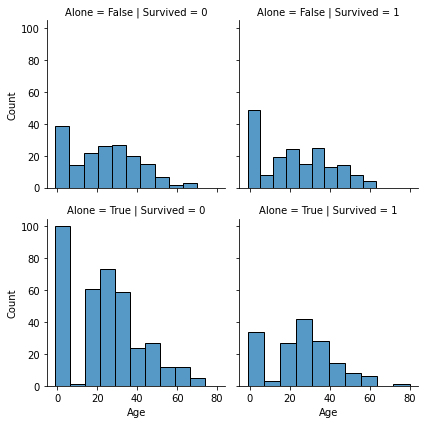

In [313]:

g = sns.FacetGrid(train_dataset, col='Survived',row='Alone')
g.map(sns.histplot, "Age",bins=10)
plt.show()

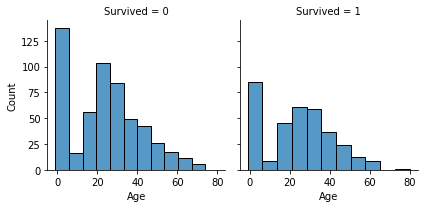

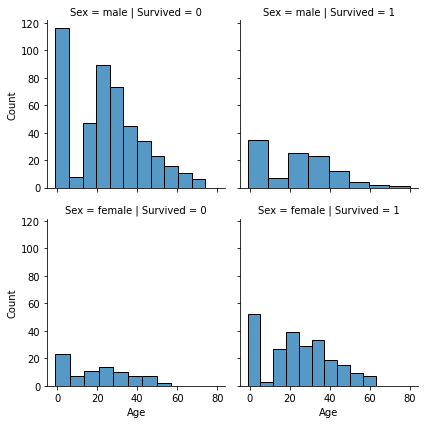

In [314]:
#Visualize some data to get some idea
g = sns.FacetGrid(train_dataset, col='Survived')
g.map(sns.histplot, "Age")
plt.show()

g = sns.FacetGrid(train_dataset, col='Survived',row='Sex')
g.map(sns.histplot, "Age")
plt.show()

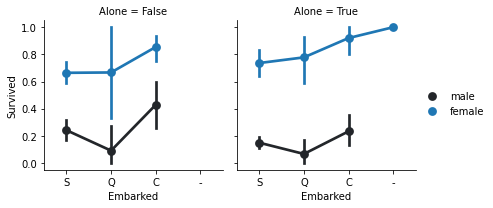

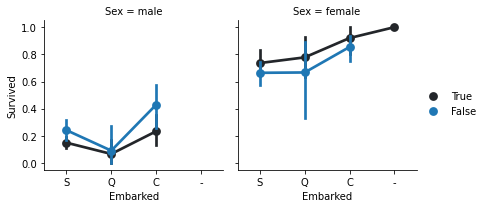

In [316]:
g = sns.FacetGrid(train_dataset, col="Alone")
g.map(sns.pointplot, 'Embarked',"Survived", "Sex", order=["S","Q","C","-"],hue_order=["male","female"])
g.add_legend()
plt.show()

g = sns.FacetGrid(train_dataset, col="Sex")
g.map(sns.pointplot, 'Embarked',"Survived", "Alone", order=["S","Q","C","-"],hue_order=[True,False])
g.add_legend()
plt.show()
#Somehow if youre a man and youre alone, you die more easily
#but if youre a woman and youre alone, you more likely to survived?


/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


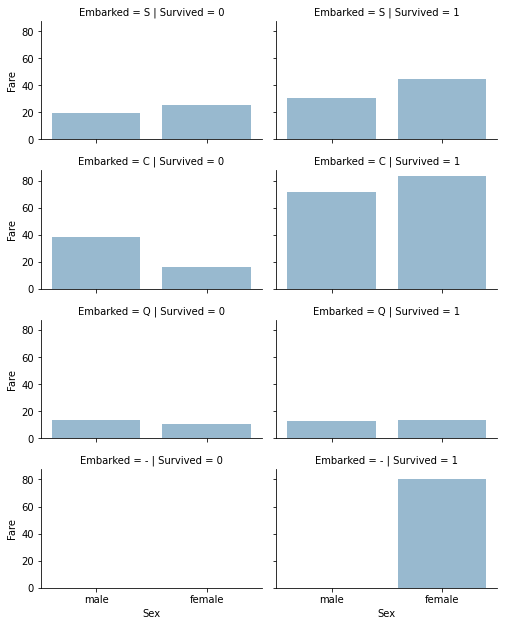

In [317]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_dataset, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None,order=["male","female"])
grid.add_legend()

In [326]:
train_dataset.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [323]:
#print(train_dataset["Embarked"].nunique()+train_dataset["Sex"].nunique()+train_dataset["#"].nunique()+train_dataset["Alone"].nunique())
#print(len(train_dataset.columns) - 4 + train_dataset["Embarked"].nunique()+train_dataset["Sex"].nunique()+train_dataset["#"].nunique()+train_dataset["Alone"].nunique())
ct = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [2,7,20])], remainder='passthrough')
train_dataset = ct.fit_transform(train_dataset)
print(train_dataset[0])


[1.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 1 3
 'Braund, Mr. Owen Harris' 'male' 22.0 0 'A/5 21171' 7.25 0 1 False nan
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 21171.0 'Braund' 'Harris' ' Mr']


In [122]:
train_dataset["#"].unique()
train_dataset["#"].nunique()
(train_dataset["Last Name"].value_counts())
#print(train_dataset["#"].value_counts())
#print(train_dataset["#"].value_counts())
#print(train_dataset["FamSize"].value_counts())




 John                   9
 James                  7
 William                6
 Mary                   6
 Bertha                 4
                       ..
 Nora A                 1
 Howard Hugh "Harry"    1
 Hudson Trevor          1
 Margaret               1
 Karl Howell            1
Name: Last Name, Length: 799, dtype: int64


In [42]:
train_dataset = train_dataset.drop(["Name", "Ticket"], axis=1)
train_feat = train_dataset[["Survived"]].copy()
train_label = train_dataset.drop(["Survived"], axis=1)

In [226]:
ann = tfk.models.Sequential()
ann.add(tfk.layers.Dense(units=6, activation='relu'))
ann.add(tfk.layers.Dense(units=8, activation='relu'))
ann.add(tfk.layers.Dense(units=6, activation='relu'))

NameError: name 'tfk' is not defined

In [19]:
normalizer = preprocessing.Normalization(axis=1)
normalizer.adapt(np.array(["PassengerId","Survived","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
train_dataset.head(100)
#test_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S
